In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
import os
import zipfile
import io
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
IM_SIZE = 224

In [43]:
def preprocess_image(image, label):
    # Image data augmentation (you can customize this part)
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)

    # Rescaling pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [44]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
#     preprocessing_function=preprocess_image
)

In [45]:
path='/kaggle/input/freshness-staleness/dataset'

In [46]:
dataset = tf.keras.utils.image_dataset_from_directory(
# fresh_stale_dataset = datagen.flow_from_directory(
    path,
    shuffle=True,  # will do the shuffling later
    batch_size=1,
    image_size=(IM_SIZE, IM_SIZE),
    interpolation='bilinear',
    label_mode='categorical',
    seed = 123,
#     label_mode = 'binary',

)
class_names = dataset.class_names
class_names

Found 32246 files belonging to 12 classes.


['Fresh Apple',
 'Fresh Banana',
 'Fresh Mango',
 'Fresh Orange',
 'Fresh Potato',
 'Fresh Tomato',
 'Stale Apple',
 'Stale Banana',
 'Stale Mango',
 'Stale Orange',
 'Stale Potato',
 'Stale Tomato']

In [47]:
dataset.map(preprocess_image)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [48]:
for image, label in dataset.take(12):
    print(image.shape, label.numpy())

(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(1, 224, 224, 3) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


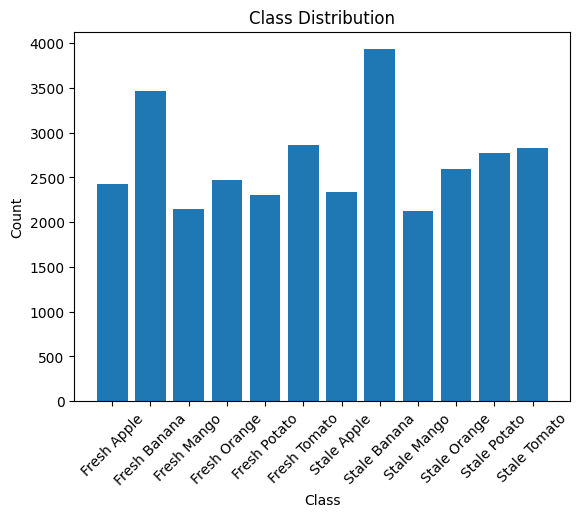

In [67]:
labels = []
for _, label in dataset:
    labels.append(label.numpy())

# Flatten the list of labels
labels = [label.argmax() for sublist in labels for label in sublist]

# Plot the class distribution
plt.bar(range(len(dataset.class_names)), [labels.count(i) for i in range(len(dataset.class_names))])
plt.xticks(range(len(dataset.class_names)), dataset.class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [49]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = dataset.skip(
        int(TRAIN_RATIO * DATASET_SIZE)).take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = dataset.skip(int(
        (TRAIN_RATIO + VAL_RATIO) * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [50]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(
    dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [51]:
(len(dataset), len(train_dataset), len(val_dataset), len(test_dataset))

(32246, 25796, 3224, 3224)

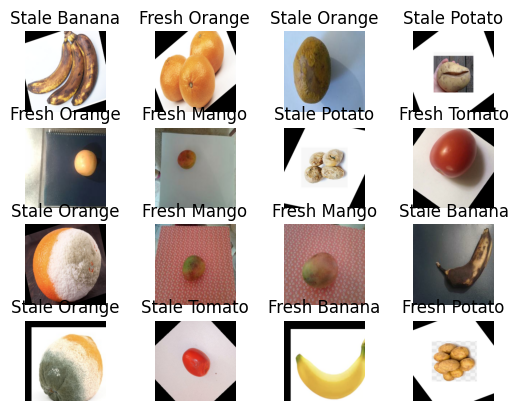

In [52]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    image = np.squeeze(image, axis=0).astype("uint8")
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_idx = tf.argmax(tf.cast(label, dtype=tf.int32), axis=1).numpy()

    inferred_label = class_names[class_idx[0]]
    plt.title(inferred_label)
    plt.axis('off')

plt.show()

In [53]:
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))

In [54]:
def squeeze_function(x, y):
    return tf.squeeze(x, axis=0), tf.squeeze(y, axis=0)

train_dataset = train_dataset.map(squeeze_function).shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(squeeze_function).shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.AUTOTUNE)

In [55]:
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))

In [56]:
import keras
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50

In [57]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IM_SIZE, IM_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [68]:
# import tensorflow as tf

# # Sequential model for clear structure
# model = Sequential([

#     # Initial convolutional block with dropout
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3)),
#     MaxPooling2D((2, 2)),
#     Dropout(0.2),  # Prevent overfitting early on

#     # Deeper convolutional blocks with varying kernel sizes
#     Conv2D(64, (5, 5), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Transition to fully connected layers
#     Flatten(),
#     Dense(128, activation='relu'),  # More neurons for complex task
#     Dropout(0.5),  # Further regularization

#     # Final output layer with 12 classes (6 fruits/vegetables x 2 freshness levels)
#     Dense(12, activation='softmax')
# ])


In [69]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))  

model = Sequential()
model.add(base_model_vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))  # num_classes is the number of classes in your dataset


58889256/58889256 [==============================] - 2s 0us/step


In [70]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 12)                3084      
                                                                 
Total params: 21140556 (80.64 MB)
Trainable params: 21140556 (80.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=500,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1, batch_size=100, callbacks = [early_stopping])


Epoch 1/20
321/404 [======================>.......] - ETA: 1:03 - loss: 2.6165 - accuracy: 0.2020